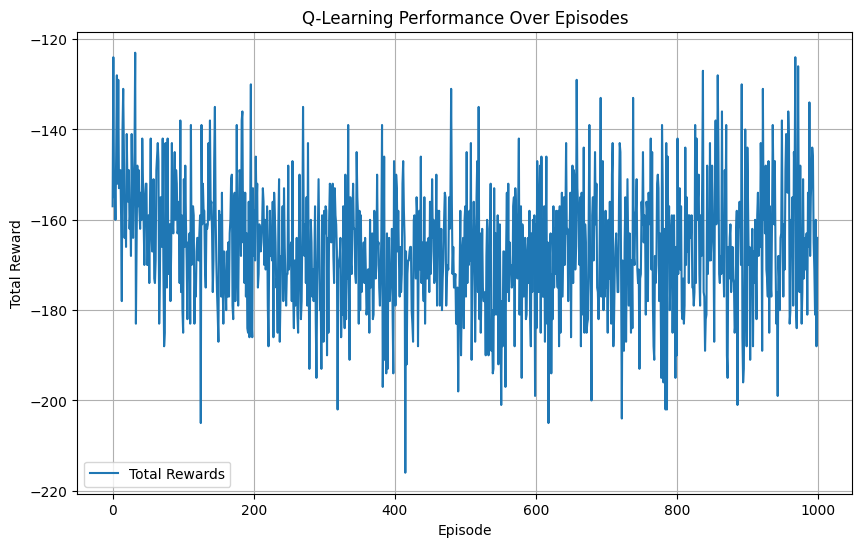

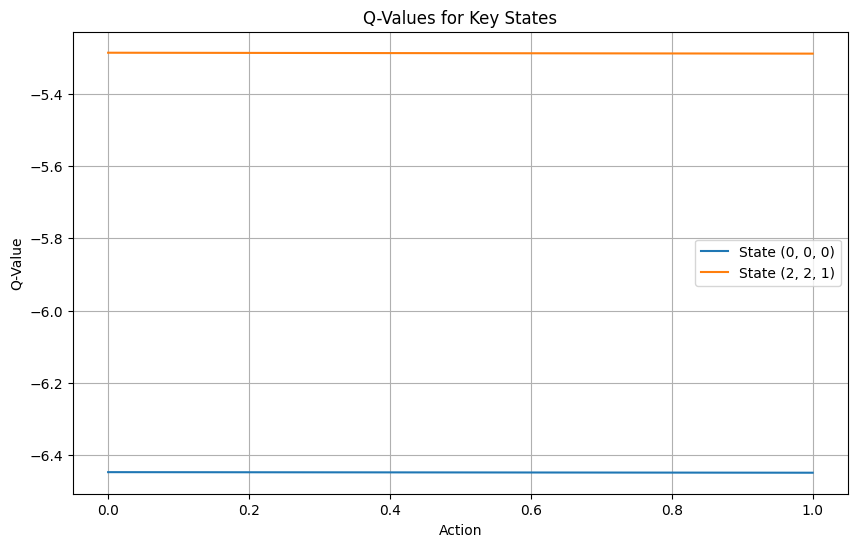

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class TrafficEnv:
    def __init__(self):
        # State space: (highway density, ramp density, light state)
        self.state_space = [(i, j, k) for i in range(3) for j in range(3) for k in range(2)]
        self.action_space = [0, 1]  # Actions: 0 (green ramp light), 1 (red ramp light)

        self.current_state = None
        self.reset()

    def reset(self):
        """Reset the environment to an initial random state."""
        highway_density = np.random.choice([0, 1, 2])
        ramp_density = np.random.choice([0, 1, 2])
        light_state = np.random.choice([0, 1])
        self.current_state = (highway_density, ramp_density, light_state)
        return self.state_to_index(self.current_state)

    def state_to_index(self, state):
        """Convert a state tuple to its corresponding index."""
        return self.state_space.index(state)

    def step(self, action):
        """Execute an action and update the environment state."""
        highway_density, ramp_density, light_state = self.current_state

        # Simulate traffic dynamics
        if action == 0:  # Green light
            ramp_density = max(0, ramp_density - 1)
        else:  # Red light
            ramp_density = min(2, ramp_density + 1)

        # Update highway density randomly (simplified dynamics)
        highway_density = np.random.choice([0, 1, 2])

        # Update state
        light_state = action
        self.current_state = (highway_density, ramp_density, light_state)

        # Reward: Encourage less ramp waiting and smooth highway flow
        reward = -highway_density - ramp_density
        done = False  # No terminal condition in this example

        return self.state_to_index(self.current_state), reward, done, {}

# Q-Learning Parameters
LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.9
EPSILON = 0.1  # Exploration probability
EPISODES = 1000

# Initialize environment and Q-table
env = TrafficEnv()
num_states = len(env.state_space)
num_actions = len(env.action_space)
Q_table = np.zeros((num_states, num_actions))

# Track rewards for visualization
total_rewards = []

# Q-Learning Algorithm
for episode in range(EPISODES):
    state = env.reset()
    total_reward = 0

    for _ in range(100):  # Maximum steps per episode
        # Choose action: Explore or Exploit
        if np.random.uniform(0, 1) < EPSILON:
            action = np.random.choice(env.action_space)  # Explore
        else:
            action = np.argmax(Q_table[state])  # Exploit

        # Take action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # Update Q-value
        Q_table[state, action] = Q_table[state, action] + LEARNING_RATE * (
            reward + DISCOUNT_FACTOR * np.max(Q_table[next_state]) - Q_table[state, action]
        )

        state = next_state
        total_reward += reward

        if done:
            break

    total_rewards.append(total_reward)

# Visualization
# Total rewards per episode
plt.figure(figsize=(10, 6))
plt.plot(total_rewards, label='Total Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning Performance Over Episodes')
plt.legend()
plt.grid()
plt.show()

# Q-Values for key states
key_states = [(0, 0, 0), (2, 2, 1)]  # Example key states
key_state_indices = [env.state_to_index(state) for state in key_states]

plt.figure(figsize=(10, 6))
for idx, state_idx in enumerate(key_state_indices):
    plt.plot(Q_table[state_idx], label=f'State {key_states[idx]}')

plt.xlabel('Action')
plt.ylabel('Q-Value')
plt.title('Q-Values for Key States')
plt.legend()
plt.grid()
plt.show()


In [11]:
import traci
import numpy as np
import tensorflow as tf
import pickle
import time
import subprocess

# Constants
NUM_PHASES = 2  # Number of traffic light phases (adjust as needed)
STATE_DIM = 6  # Number of state variables: [highway_queue_length, ramp_queue_length, highway_speed, ramp_speed, highway_occupancy, ramp_occupancy]
ACTION_DIM = NUM_PHASES  # Number of possible traffic light phases
GAMMA = 0.9
EPSILON = 0.1
ALPHA = 0.001
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32
NUM_EPISODES = 100

# Q-network (Deep Q-Network)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(STATE_DIM,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(ACTION_DIM, activation="linear"),
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=ALPHA), loss="mse")

# Replay memory
memory = []


def get_state():
    """Retrieve the state from the SUMO simulation."""
    highway_queue = traci.edge.getLastStepHaltingNumber("highway")
    ramp_queue = traci.edge.getLastStepHaltingNumber("ramp")
    highway_speed = traci.edge.getLastStepMeanSpeed("highway")
    ramp_speed = traci.edge.getLastStepMeanSpeed("ramp")
    highway_occupancy = traci.edge.getLastStepOccupancy("highway")
    ramp_occupancy = traci.edge.getLastStepOccupancy("ramp")

    state = np.array([highway_queue, ramp_queue, highway_speed, ramp_speed, highway_occupancy, ramp_occupancy])
    return state


def choose_action(state):
    """Choose action using epsilon-greedy policy."""
    if np.random.rand() < EPSILON:
        return np.random.randint(ACTION_DIM)
    else:
        q_values = model.predict(state.reshape(1, -1))[0]
        return np.argmax(q_values)


def update_q_network():
    """Update the Q-network using the replay memory."""
    if len(memory) < BATCH_SIZE:
        return

    minibatch = np.array(memory)[np.random.choice(len(memory), BATCH_SIZE, replace=False)]

    states = np.vstack(minibatch[:, 0])
    actions = minibatch[:, 1].astype(int)
    rewards = minibatch[:, 2]
    next_states = np.vstack(minibatch[:, 3])
    terminals = minibatch[:, 4]

    q_values = model.predict(states)
    next_q_values = model.predict(next_states)

    for i in range(BATCH_SIZE):
        if terminals[i]:
            q_values[i, actions[i]] = rewards[i]
        else:
            q_values[i, actions[i]] = rewards[i] + GAMMA * np.max(next_q_values[i])

    model.fit(states, q_values, epochs=1, verbose=0)


def calculate_reward(state, action, next_state):
    """Reward function to optimize traffic flow."""
    highway_queue = state[0]
    ramp_queue = state[1]
    highway_speed = state[2]
    ramp_speed = state[3]

    # Example reward: minimize ramp waiting time and maximize highway speed
    reward = -(ramp_queue) + highway_speed - highway_queue + ramp_speed
    return reward


def check_if_done():
    """Check if the episode is done based on simulation time."""
    return traci.simulation.getTime() > 1000  # Example condition


# Connect to SUMO
# Start SUMO with a specified port
traci.start(["sumo", "-c", "sumo_config/simulation.sumocfg", "--remote-port", "58482"])


# Training loop
for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0

    while traci.simulation.getMinExpectedNumber() > 0:
        action = choose_action(state)

        # Apply the chosen action to the traffic light in SUMO (example: set the phase)
        traci.trafficlight.setPhase("ramp_light", action)

        # Step the simulation
        traci.simulationStep()

        # Get the next state after the simulation step
        next_state = get_state()

        # Calculate reward for the current state-action transition
        reward = calculate_reward(state, action, next_state)

        # Check if the episode is done
        done = check_if_done()

        # Log the results for debugging
        print(f"Step: {traci.simulation.getTime()}, Action: {action}, Reward: {reward}")

        # Store the experience in memory
        memory.append((state, action, reward, next_state, done))

        # Update the Q-network
        update_q_network()

        # Update the current state
        state = next_state
        total_reward += reward

        if done:
            break

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    # Save the model periodically
    if (episode + 1) % 10 == 0:
        model.save(f"trained_traffic_light_model_ql_{episode + 1}.h5")

# Close connection to SUMO
traci.close()


C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:154: UserWarning: Could not connect to TraCI server using port 58527 (TraCI server already finished). Retrying with different port.
  warnings.warn(("Could not connect to TraCI server using port %s (%s)." +
C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:154: UserWarning: Could not connect to TraCI server using port 58529 (TraCI server already finished). Retrying with different port.
  warnings.warn(("Could not connect to TraCI server using port %s (%s)." +
C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:154: UserWarning: Could not connect to TraCI server using port 58531 (TraCI server already finished). Retrying with different port.
  warnings.warn(("Could not connect to TraCI server using port %s (%s)." +
C:\Program Files (x86)\Eclipse\Sumo\tools\traci\main.py:154: UserWarning: Could not connect to TraCI server using port 58533 (TraCI server already finished). Retrying with different port.
  warnings.warn(("Could

KeyboardInterrupt: 

In [9]:
import traci
import numpy as np
import random

# Constants
NUM_PHASES = 2  # Number of traffic light phases (0: Green on ramp, 1: Green on highway)
STATE_DIM = 6  # Number of state variables: [highway_queue_length, ramp_queue_length, highway_speed, ramp_speed, highway_occupancy, ramp_occupancy]
ACTION_DIM = NUM_PHASES  # Number of possible traffic light phases
GAMMA = 0.9  # Discount factor for future rewards
EPSILON = 0.1  # Epsilon for epsilon-greedy action selection
ALPHA = 0.1  # Learning rate
MEMORY_CAPACITY = 10000  # Size of experience replay memory
BATCH_SIZE = 32  # Batch size for training (not used directly in Q-learning without experience replay)
NUM_EPISODES = 100  # Number of episodes to train

# Initialize Q-table: rows = state space, columns = action space
Q_table = np.zeros((STATE_DIM, ACTION_DIM))

def get_state():
    """Retrieve the state from the SUMO simulation."""
    highway_queue = traci.edge.getLastStepHaltingNumber("highway")
    ramp_queue = traci.edge.getLastStepHaltingNumber("ramp")
    highway_speed = traci.edge.getLastStepMeanSpeed("highway")
    ramp_speed = traci.edge.getLastStepMeanSpeed("ramp")
    highway_occupancy = traci.edge.getLastStepOccupancy("highway")
    ramp_occupancy = traci.edge.getLastStepOccupancy("ramp")

    state = np.array([highway_queue, ramp_queue, highway_speed, ramp_speed, highway_occupancy, ramp_occupancy])
    return state

def choose_action(state):
    """Choose action using epsilon-greedy policy."""
    if random.random() < EPSILON:
        # Choose a random action
        return random.randint(0, ACTION_DIM - 1)
    else:
        # Choose the action with the highest Q-value
        state_idx = np.array(state).astype(int)  # Convert state to integer for indexing (this can be refined)
        return np.argmax(Q_table[state_idx])

def calculate_reward(state, action, next_state):
    """Reward function to optimize traffic flow."""
    highway_queue = state[0]
    ramp_queue = state[1]
    highway_speed = state[2]
    ramp_speed = state[3]

    # Example reward: minimize ramp waiting time and maximize highway speed
    reward = -(ramp_queue) + highway_speed - highway_queue + ramp_speed
    return reward

def update_q_table(state, action, reward, next_state):
    """Update the Q-table using the Q-learning update rule."""
    state_idx = np.array(state).astype(int)  # Convert state to integer for indexing
    next_state_idx = np.array(next_state).astype(int)

    # Q-learning update rule
    max_next_q = np.max(Q_table[next_state_idx])
    Q_table[state_idx, action] = Q_table[state_idx, action] + ALPHA * (reward + GAMMA * max_next_q - Q_table[state_idx, action])

def check_if_done():
    """Check if the episode is done based on simulation time."""
    return traci.simulation.getTime() > 1000  # Example condition, change to your own simulation condition

# Connect to SUMO
# Try connecting to SUMO
try:
    traci.start(["sumo", "-c", r"C:\Users\lenovo\Desktop\Projet RL\sumo_config\simulation.sumocfg"])
    print("Connection successful")
    traci.close()
except Exception as e:
    print(f"Connection failed: {e}")

# Training loop
for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0

    while traci.simulation.getMinExpectedNumber() > 0:
        action = choose_action(state)

        # Apply the chosen action to the traffic light in SUMO (example: set the phase)
        traci.trafficlight.setPhase("ramp_light", action)

        # Step the simulation
        traci.simulationStep()

        # Get the next state after the simulation step
        next_state = get_state()

        # Calculate reward for the current state-action transition
        reward = calculate_reward(state, action, next_state)

        # Update the Q-table
        update_q_table(state, action, reward, next_state)

        # Update the current state
        state = next_state
        total_reward += reward

        if check_if_done():
            break

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# Save Q-table for future use
np.save("q_table.npy", Q_table)

# Close connection to SUMO
traci.close()


Connection successful


FatalTraCIError: Connection already closed.

In [ ]:
import traci
import numpy as np
import random

# Constants
NUM_PHASES = 2  # Number of traffic light phases
STATE_DIM = 6  # Number of state variables
ACTION_DIM = NUM_PHASES  # Number of actions
GAMMA = 0.9  # Discount factor
EPSILON = 0.1  # Epsilon for epsilon-greedy action selection
ALPHA = 0.001  # Learning rate
NUM_EPISODES = 100  # Number of episodes

# Initialize Q-table
Q_table = np.zeros((10**STATE_DIM, ACTION_DIM))  # Assuming 10 discrete bins per state variable

def discretize_state(state, bins=10):
    return np.digitize(state, np.linspace(0, 1, bins)) - 1  # Normalize and discretize

def get_state():
    """Retrieve and discretize the state from SUMO."""
    try:
        highway_queue = traci.edge.getLastStepHaltingNumber("E1")
        ramp_queue = traci.edge.getLastStepHaltingNumber("E4")
        highway_speed = traci.edge.getLastStepMeanSpeed("E1") / traci.lane.getMaxSpeed("E1_0")
        ramp_speed = traci.edge.getLastStepMeanSpeed("E4") / traci.lane.getMaxSpeed("E4_0")
        highway_occupancy = traci.edge.getLastStepVehicleNumber("E1")
        ramp_occupancy = traci.edge.getLastStepVehicleNumber("E4")

        state = np.array([highway_queue, ramp_queue, highway_speed, ramp_speed, highway_occupancy, ramp_occupancy])
        return discretize_state(state)  # Return discrete state
    except Exception as e:
        print(f"Error retrieving state: {e}")
        return np.zeros(STATE_DIM, dtype=int)  # Fallback to a default state

def choose_action(state):
    """Epsilon-greedy action selection."""
    if random.random() < EPSILON:
        return random.randint(0, ACTION_DIM - 1)
    state_idx = int("".join(map(str, state)))  # Combine discrete state into unique index
    return np.argmax(Q_table[state_idx])

# def calculate_reward(state, action, next_state):
#     # Example reward considering traffic light action effect
#     highway_improvement = next_state[2] - state[2]
#     ramp_improvement = next_state[3] - state[3]
#     queue_reduction = state[0] - next_state[0] + state[1] - next_state[1]
#     return queue_reduction + 0.5 * (highway_improvement + ramp_improvement)

def calculate_reward(state, action, next_state):
    highway_queue = state[0]
    ramp_queue = state[1]
    highway_speed = state[2]
    ramp_speed = state[3]
    next_highway_queue = next_state[0]
    next_ramp_queue = next_state[1]
    
    # Reward for reducing queues and maintaining high speeds
    reward = (highway_speed + ramp_speed) - (next_highway_queue - highway_queue) - (next_ramp_queue - ramp_queue)
    return reward


def update_q_table(state, action, reward, next_state):
    """Update Q-table using Q-learning rule."""
    state_idx = int("".join(map(str, state)))
    next_state_idx = int("".join(map(str, next_state)))
    max_next_q = np.max(Q_table[next_state_idx])
    Q_table[state_idx, action] += ALPHA * (reward + GAMMA * max_next_q - Q_table[state_idx, action])

# Simulation and Training
try:
    traci.start(["sumo", "-c", r"C:\Users\lenovo\Desktop\Projet RL\sumo_config\simulation.sumocfg"])
    print("SUMO connected successfully.")

    for episode in range(NUM_EPISODES):
        state = get_state()
        total_reward = 0

        while traci.simulation.getMinExpectedNumber() > 0:
            action = choose_action(state)
            traci.trafficlight.setPhase("J7", action)  # Apply action
            traci.simulationStep()  # Step simulation
            next_state = get_state()
            reward = calculate_reward(state, action, next_state)
            update_q_table(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    np.save("q_table.npy", Q_table)  # Save the Q-table
finally:
    traci.close()


SUMO connected successfully.
Episode 1, Total Reward: 0.0
Episode 2, Total Reward: 0
Episode 3, Total Reward: 0
Episode 4, Total Reward: 0
Episode 5, Total Reward: 0
Episode 6, Total Reward: 0
Episode 7, Total Reward: 0
Episode 8, Total Reward: 0
Episode 9, Total Reward: 0
Episode 10, Total Reward: 0
Episode 11, Total Reward: 0
Episode 12, Total Reward: 0
Episode 13, Total Reward: 0
Episode 14, Total Reward: 0
Episode 15, Total Reward: 0
Episode 16, Total Reward: 0
Episode 17, Total Reward: 0
Episode 18, Total Reward: 0
Episode 19, Total Reward: 0
Episode 20, Total Reward: 0
Episode 21, Total Reward: 0
Episode 22, Total Reward: 0
Episode 23, Total Reward: 0
Episode 24, Total Reward: 0
Episode 25, Total Reward: 0
Episode 26, Total Reward: 0
Episode 27, Total Reward: 0
Episode 28, Total Reward: 0
Episode 29, Total Reward: 0
Episode 30, Total Reward: 0
Episode 31, Total Reward: 0
Episode 32, Total Reward: 0
Episode 33, Total Reward: 0
Episode 34, Total Reward: 0
Episode 35, Total Reward: 